In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt
import numpy as np

from hydra import initialize, compose
from hydra.utils import instantiate

from pathlib import Path

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.encoder.encoder import Encoder
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

from pytorch_lightning.utilities import move_data_to_device

output_dir = Path("./plot_output/vsbc_plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-29-3/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

bands = ("u", "g", "r", "i", "z", "y")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
tile_slen = notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder = bliss_encoder.eval()

In [4]:
def move_tile_cat_to_device(ori_tile_cat: TileCatalog, device):
    tile_dict = move_data_to_device(ori_tile_cat.data, device=device)
    return TileCatalog(tile_dict)

In [5]:
bliss_vsbc_tile_cat_list = []
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_on_device = move_data_to_device(batch, device=device)
    with torch.no_grad():
        bliss_vsbc_tile_cat = bliss_encoder.sample_vsbc(batch_on_device, use_mode=True)
        bliss_vsbc_tile_cat = bliss_vsbc_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,
        )
    bliss_vsbc_tile_cat_list.append(move_tile_cat_to_device(bliss_vsbc_tile_cat, device="cpu"))

100%|██████████| 391/391 [02:13<00:00,  2.92it/s]


In [6]:
ellipticity1_vsbc_list = []
ellipticity2_vsbc_list = []
locs1_vsbc_list = []
locs2_vsbc_list = []
star_flux_vsbc_dict = {band: [] for band in bands}
galaxy_flux_vsbc_dict = {band: [] for band in bands}
is_on_mask_list = []
for bliss_vsbc_tile_cat in bliss_vsbc_tile_cat_list:
    ellipticity_vsbc = bliss_vsbc_tile_cat["ellipticity_vsbc"]
    ellipticity1_vsbc_list.append(ellipticity_vsbc[..., 0])
    ellipticity2_vsbc_list.append(ellipticity_vsbc[..., 1])
    is_on_mask_list.append(bliss_vsbc_tile_cat.is_on_mask)

    locs_vsbc = bliss_vsbc_tile_cat["locs_vsbc"]
    locs1_vsbc_list.append(locs_vsbc[..., 0])
    locs2_vsbc_list.append(locs_vsbc[..., 1])
    
    star_flux_vsbc = bliss_vsbc_tile_cat["star_fluxes_vsbc"]
    galaxy_flux_vsbc = bliss_vsbc_tile_cat["galaxy_fluxes_vsbc"]
    for i, band in enumerate(bands):
        star_flux_vsbc_dict[band].append(star_flux_vsbc[..., i])
        galaxy_flux_vsbc_dict[band].append(galaxy_flux_vsbc[..., i])

ellipticity1_vsbc = torch.cat(ellipticity1_vsbc_list, dim=0).flatten()
ellipticity2_vsbc = torch.cat(ellipticity2_vsbc_list, dim=0).flatten()
locs1_vsbc = torch.cat(locs1_vsbc_list, dim=0).flatten()
locs2_vsbc = torch.cat(locs2_vsbc_list, dim=0).flatten()
is_on_mask = torch.cat(is_on_mask_list, dim=0).flatten()

for k, v in star_flux_vsbc_dict.items():
    star_flux_vsbc_dict[k] = torch.cat(v, dim=0).flatten()

for k, v in galaxy_flux_vsbc_dict.items():
    galaxy_flux_vsbc_dict[k] = torch.cat(v, dim=0).flatten()

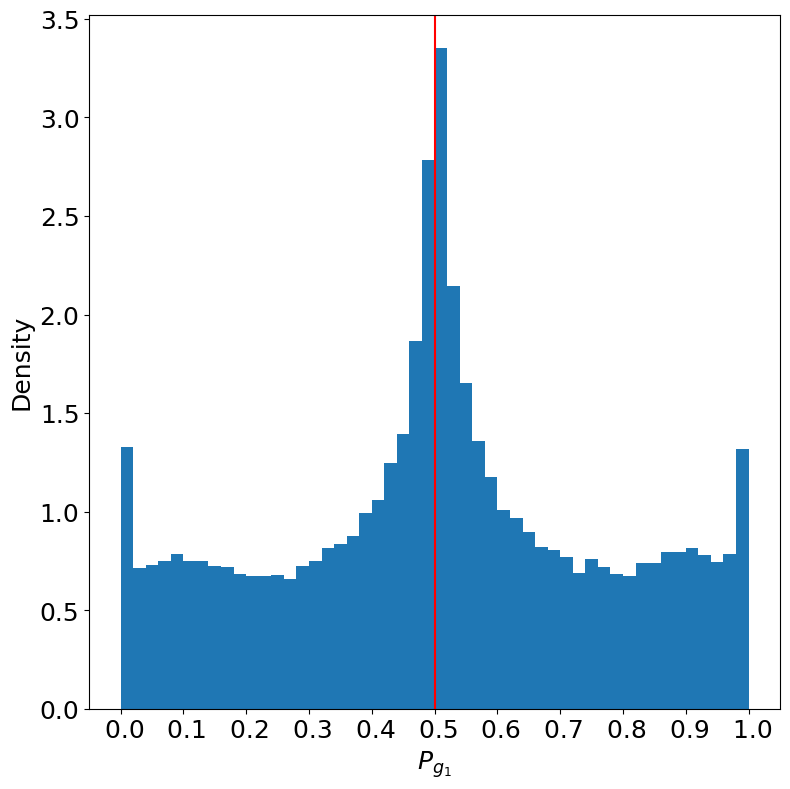

In [7]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

ax.hist(ellipticity1_vsbc[is_on_mask & ~ellipticity1_vsbc.isnan()], density=True, bins=50)
ax.axvline(0.5, color="red")
ax.set_ylabel("Density", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("$P_{g_1}$", fontsize=NoteBookVariables.font_size)
ax.set_xticks(np.linspace(0.0, 1.0, num=11))
ax.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
ax.tick_params(labelsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "g1_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

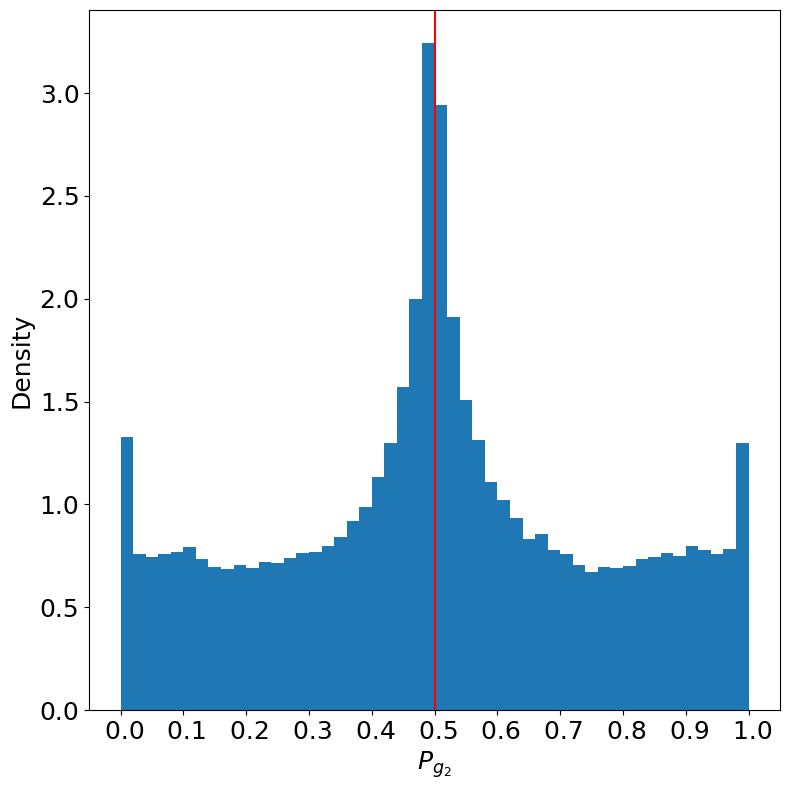

In [8]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

ax.hist(ellipticity2_vsbc[is_on_mask & ~ellipticity2_vsbc.isnan()], density=True, bins=50)
ax.axvline(0.5, color="red")
ax.set_ylabel("Density", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("$P_{g_2}$", fontsize=NoteBookVariables.font_size)
ax.set_xticks(np.linspace(0.0, 1.0, num=11))
ax.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
ax.tick_params(labelsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "g2_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

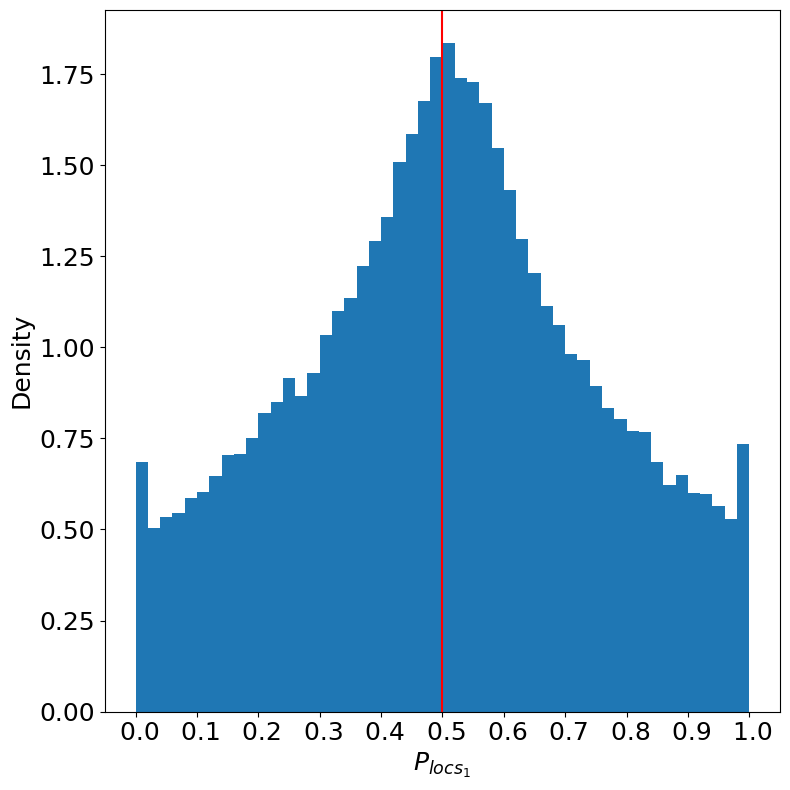

In [9]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

ax.hist(locs1_vsbc[is_on_mask & ~locs1_vsbc.isnan()], density=True, bins=50)
ax.axvline(0.5, color="red")
ax.set_ylabel("Density", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("$P_{locs_1}$", fontsize=NoteBookVariables.font_size)
ax.set_xticks(np.linspace(0.0, 1.0, num=11))
ax.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
ax.tick_params(labelsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "locs1_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

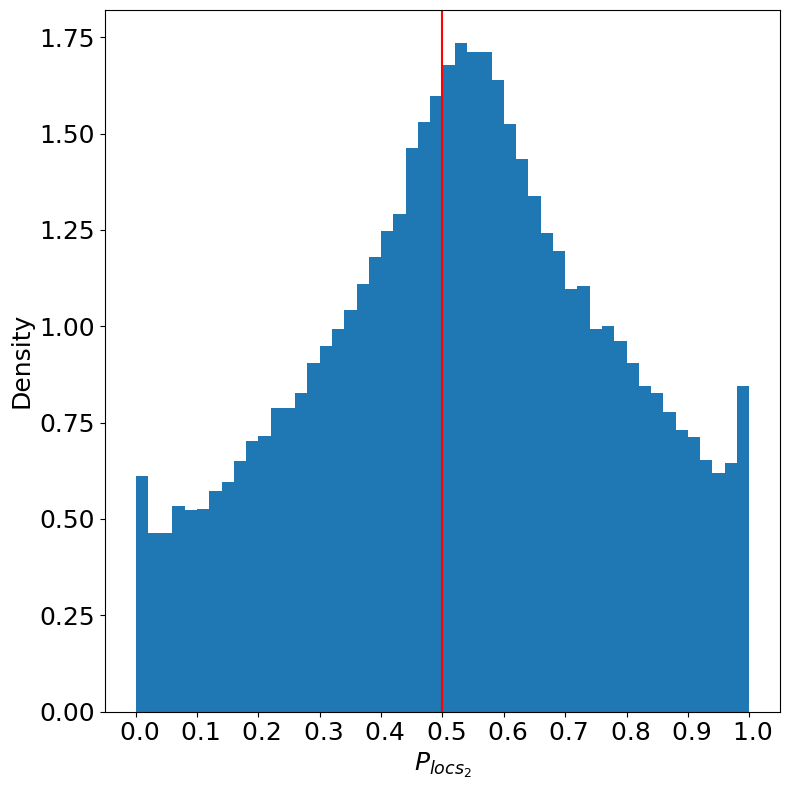

In [10]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

ax.hist(locs2_vsbc[is_on_mask & ~locs2_vsbc.isnan()], density=True, bins=50)
ax.axvline(0.5, color="red")
ax.set_ylabel("Density", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("$P_{locs_2}$", fontsize=NoteBookVariables.font_size)
ax.set_xticks(np.linspace(0.0, 1.0, num=11))
ax.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
ax.tick_params(labelsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "locs2_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

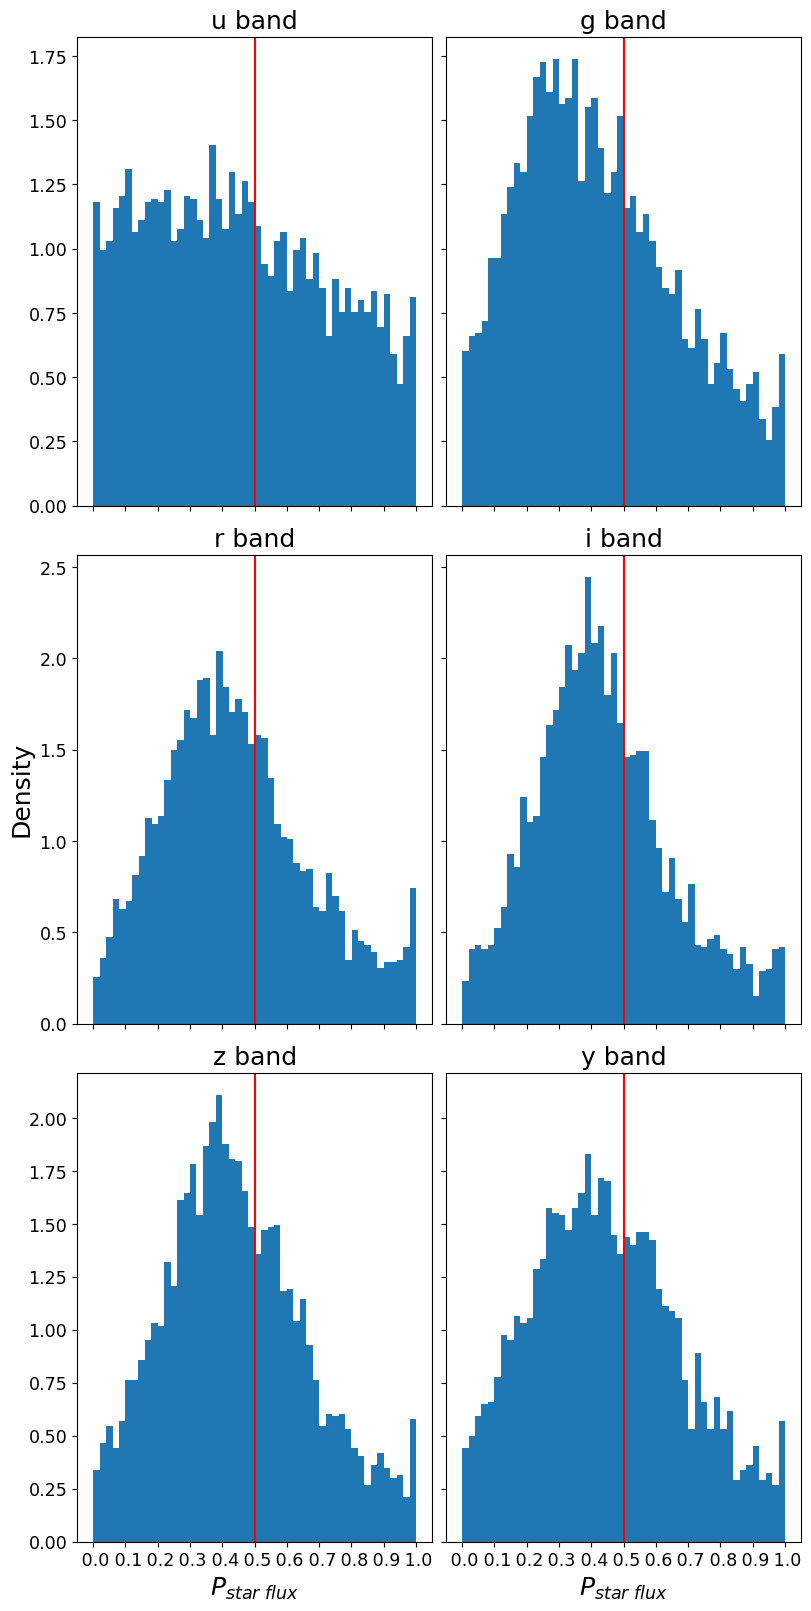

In [11]:
fig, axes = plt.subplots(3, 2, 
                         figsize=(NoteBookVariables.figsize[0], NoteBookVariables.figsize[1] * 2), 
                         sharex="col", 
                         sharey="row",
                         layout="constrained")

for i, band in enumerate(bands):
    col_index = i % 2
    row_index = i // 2
    ax = axes[row_index, col_index]
    star_flux_vsbc = star_flux_vsbc_dict[band]
    star_flux_vsbc = star_flux_vsbc[is_on_mask & ~star_flux_vsbc.isnan()]
    ax.hist(star_flux_vsbc, density=True, bins=50)
    ax.axvline(0.5, color="red")
    ax.set_title(f"{band} band", fontsize=NoteBookVariables.font_size)
    ax.grid(visible=False)

axes[1, 0].set_ylabel("Density", fontsize=NoteBookVariables.font_size)
axes[2, 0].set_xticks(np.linspace(0.0, 1.0, num=11))
axes[2, 0].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
axes[2, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[2, 0].set_xlabel("$P_{star\ flux}$", fontsize=NoteBookVariables.font_size)
axes[2, 1].set_xticks(np.linspace(0.0, 1.0, num=11))
axes[2, 1].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
axes[2, 1].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[2, 1].set_xlabel("$P_{star\ flux}$", fontsize=NoteBookVariables.font_size)

axes[0, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[1, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[2, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)

fig.savefig(output_dir / "star_flux_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

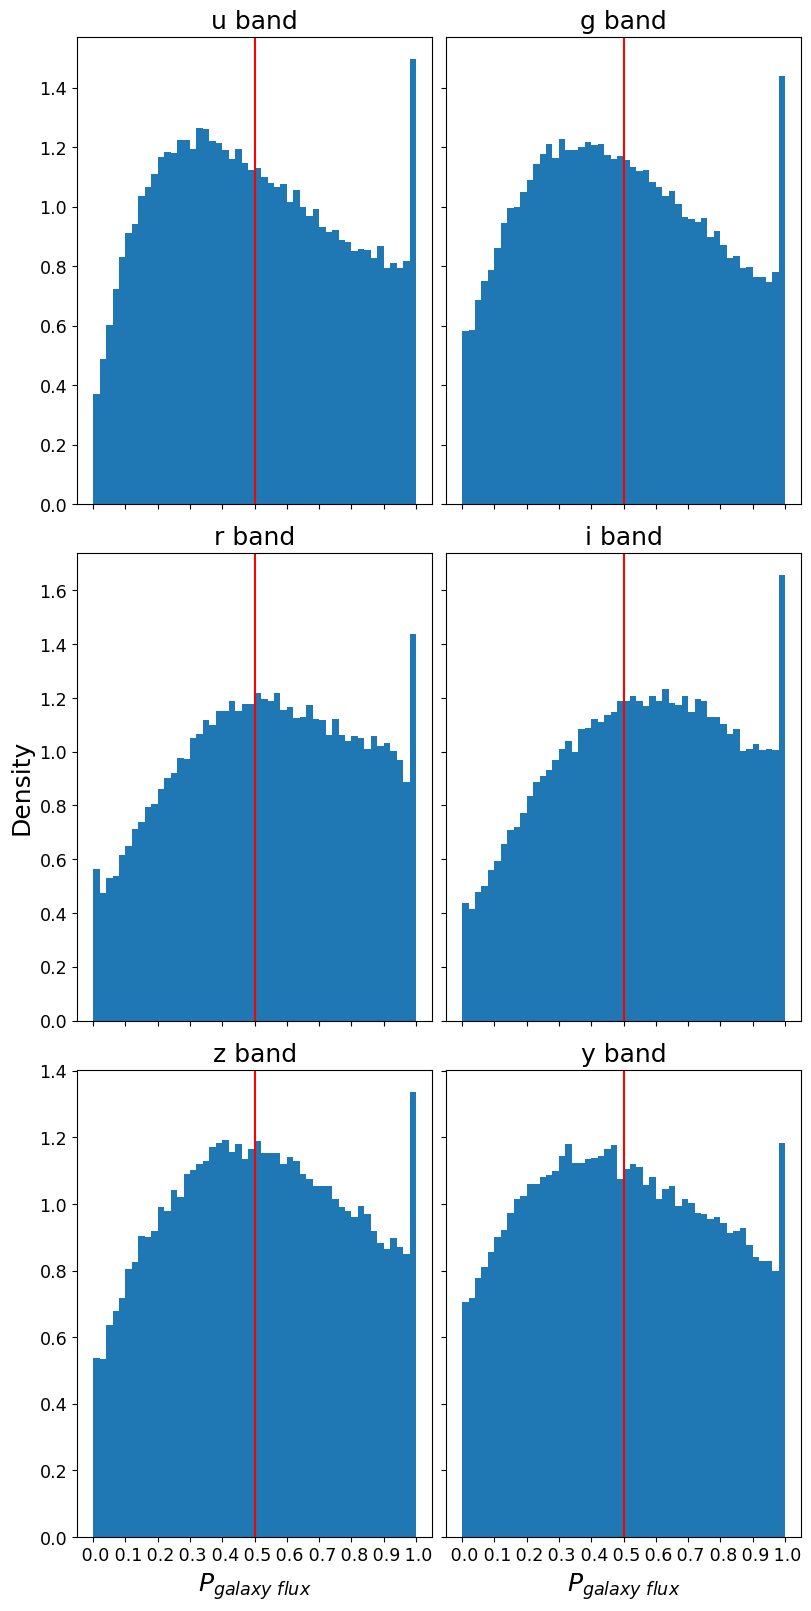

In [12]:
fig, axes = plt.subplots(3, 2, 
                         figsize=(NoteBookVariables.figsize[0], NoteBookVariables.figsize[1] * 2), 
                         sharex="col", 
                         sharey="row",
                         layout="constrained")

for i, band in enumerate(bands):
    col_index = i % 2
    row_index = i // 2
    ax = axes[row_index, col_index]
    galaxy_flux_vsbc = galaxy_flux_vsbc_dict[band]
    galaxy_flux_vsbc = galaxy_flux_vsbc[is_on_mask & ~galaxy_flux_vsbc.isnan()]
    ax.hist(galaxy_flux_vsbc, density=True, bins=50)
    ax.axvline(0.5, color="red")
    ax.set_title(f"{band} band", fontsize=NoteBookVariables.font_size)
    ax.grid(visible=False)

axes[1, 0].set_ylabel("Density", fontsize=NoteBookVariables.font_size)
axes[2, 0].set_xticks(np.linspace(0.0, 1.0, num=11))
axes[2, 0].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
axes[2, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[2, 0].set_xlabel("$P_{galaxy\ flux}$", fontsize=NoteBookVariables.font_size)
axes[2, 1].set_xticks(np.linspace(0.0, 1.0, num=11))
axes[2, 1].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=11)])
axes[2, 1].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[2, 1].set_xlabel("$P_{galaxy\ flux}$", fontsize=NoteBookVariables.font_size)

axes[0, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[1, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)
axes[2, 0].tick_params(labelsize=NoteBookVariables.font_size * 0.7)

fig.savefig(output_dir / "galaxy_flux_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()